In [68]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from time import clock
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import defaultdict, Counter
# from helpers import cluster_acc, myGMM,nn_arch,nn_reg
from sklearn.metrics import adjusted_mutual_info_score, accuracy_score, homogeneity_score, silhouette_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import sys
import warnings
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
matplotlib.rc('figure', figsize=[10,5])


# pulling dataset 1 Churn dataset

In [4]:
df_churn = pd.read_csv('data/Telecom_customer_churn.csv', index_col = False)
print(df_churn.dtypes)
print(f'unique Value of our Target_class:  {df_churn.Churn.unique()}')

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object
unique Value of our Target_class:  ['No' 'Yes']


In [7]:
# Creating categorical values nto one hot encoding and dropping null values
#Removing missing values 
df_churn.dropna(inplace = True)
#Remove customer IDs from the data set
df2 = df_churn.iloc[:,1:]
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)
# normalize features for better performance 
#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

predictors_list = ['tenure','InternetService_Fiber optic', 'InternetService_No', 'PaymentMethod_Electronic check',
       'OnlineSecurity_No', 'OnlineBackup_No', 'OnlineBackup_No internet service',  'StreamingTV_No internet service',
       'OnlineSecurity_No internet service','DeviceProtection_No','StreamingMovies_No internet service',
       'DeviceProtection_No internet service','TechSupport_No', 'TechSupport_No internet service','Contract_Two year','Contract_Month-to-month']

# min_max_scaler 

target = df_dummies['Churn']
X = df_dummies[predictors_list] # convert to numpy array
print(X.shape)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)

print(x_scaled.shape)
df_churn_scaled = pd.DataFrame(x_scaled, columns=predictors_list)
df_churn_scaled['Churn'] = target
df_churn_scaled.head()

(7043, 16)
(7043, 16)


,tenure,InternetService_Fiber optic,InternetService_No,PaymentMethod_Electronic check,OnlineSecurity_No,OnlineBackup_No,OnlineBackup_No internet service,StreamingTV_No internet service,OnlineSecurity_No internet service,DeviceProtection_No,StreamingMovies_No internet service,DeviceProtection_No internet service,TechSupport_No,TechSupport_No internet service,Contract_Two year,Contract_Month-to-month,Churn
0,0.013889,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,0.472222,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,0.625000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.027778,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1


# reading Product propensity data

In [8]:
df_cust = pd.read_csv('data/purchase_propensity_data.csv', index_col = False)
print(df_cust.dtypes)
print(f'unique Value of our Target_class:  {df_cust.ordered.unique()}')

UserID                     object
basket_icon_click           int64
basket_add_list             int64
basket_add_detail           int64
sort_by                     int64
image_picker                int64
account_page_click          int64
promo_banner_click          int64
detail_wishlist_add         int64
list_size_dropdown          int64
closed_minibasket_click     int64
checked_delivery_detail     int64
checked_returns_detail      int64
sign_in                     int64
saw_checkout                int64
saw_sizecharts              int64
saw_delivery                int64
saw_account_upgrade         int64
saw_homepage                int64
device_mobile               int64
device_computer             int64
device_tablet               int64
returning_user              int64
loc_uk                      int64
ordered                     int64
dtype: object
unique Value of our Target_class:  [0 1]


In [9]:
df_cust.columns

Index(['UserID', 'basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'sort_by', 'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homepage', 'device_mobile', 'device_computer', 'device_tablet',
       'returning_user', 'loc_uk', 'ordered'],
      dtype='object')

In [10]:
# doing Min_max scaing

In [12]:
predictors_list = ['basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'sort_by', 'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homepage', 'device_mobile', 'device_computer', 'device_tablet',
       'returning_user', 'loc_uk']

# min_max_scaler 

target_order = df_cust['ordered']
order_X = df_cust[predictors_list] # convert to numpy array
print(order_X.shape)
min_max_scaler = preprocessing.MinMaxScaler()
order_x_scaled = min_max_scaler.fit_transform(order_X)

print(order_x_scaled.shape)
df_order_scaled = pd.DataFrame(order_x_scaled, columns=predictors_list)
df_order_scaled['ordered'] = target_order
df_order_scaled.head()

(38186, 23)
(38186, 23)


,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,checked_delivery_detail,checked_returns_detail,sign_in,saw_checkout,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0


In [ ]:
# spliting into x and y 

In [33]:
X_churn = df_churn_scaled.drop('Churn', 1).copy().values
Y_churn = df_churn_scaled['Churn'].copy().values
X_cust = df_order_scaled.drop('ordered', 1).copy().values
Y_cust = df_order_scaled['ordered'].copy().values

In [14]:
# Providing range for clusters from 2 to 41

In [30]:
clust_range = list(range(2,31,1))

## Telecom churn Dataset SSE Metric Elbow Method

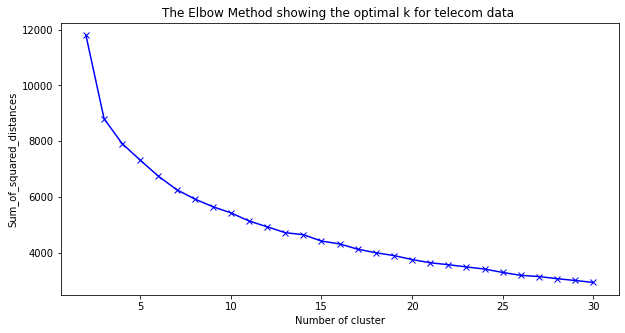

In [31]:
# Telecom churn dataset
sse_tel = {}
for cluster_size in clust_range:
    kmeans = KMeans(n_clusters=cluster_size, max_iter=10000, random_state=123).fit(X_churn)
    sse_tel [cluster_size] = kmeans.inertia_
plt.figure()
plt.plot(list(sse_tel.keys()), list(sse_tel.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel('Sum_of_squared_distances')
plt.title('The Elbow Method showing the optimal k for telecom data ')
plt.show()

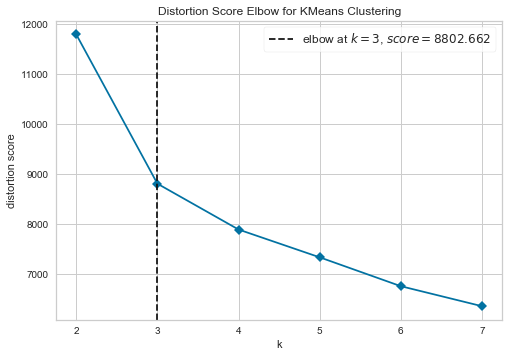

In [44]:

model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,8), timings=False)
visualizer.fit(X_churn)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [45]:
kmeans_tel = KMeans(n_clusters=3, n_init=50, max_iter=1000, random_state=123).fit(X_churn)
print(f'accuracy score based on 3 clusters :{accuracy_score((1-kmeans_tel.labels_), Y_churn)}')
print(f'adjusted_mutual_info_score based on 3 clusters :{adjusted_mutual_info_score((1-kmeans_tel.labels_), Y_churn)}')

accuracy score based on 3 clusters :0.42254720999574047
adjusted_mutual_info_score based on 3 clusters :0.12318746349876353


## cust DATASET SSE

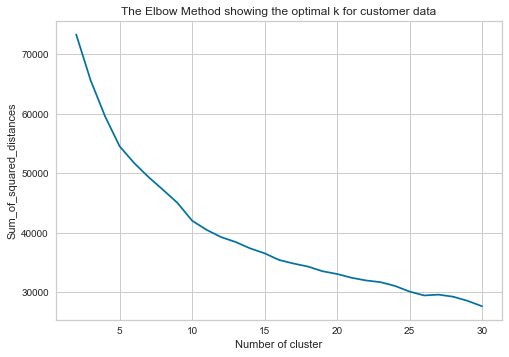

In [48]:
# Cust dataset
sse_cust = {}
for cluster_size in clust_range:
    kmeans = KMeans(n_clusters=cluster_size, max_iter=10000, random_state=123).fit(X_cust)
    sse_cust[cluster_size] = kmeans.inertia_
plt.figure()
plt.plot(list(sse_cust.keys()), list(sse_cust.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel('Sum_of_squared_distances')b
plt.title('The Elbow Method showing the optimal k for customer data')
plt.show()

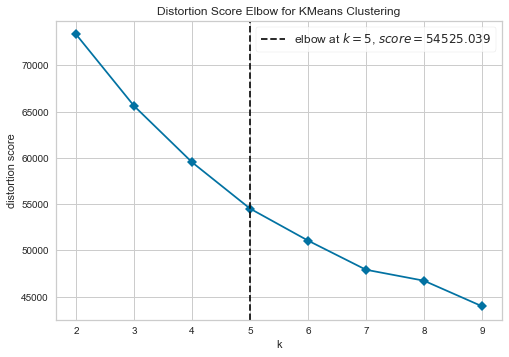

In [52]:

model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(X_cust)        # Fit the data to the visualizer
visualizer.show()   

In [56]:
kmeans_tel = KMeans(n_clusters=5, n_init=50, max_iter=1000, random_state=123).fit(X_cust)
print(f'accuracy score based on 5 clusters :{accuracy_score((1-kmeans_tel.labels_), Y_cust)}')
print(f'adjusted_mutual_info_score based on 5 clusters :{adjusted_mutual_info_score((1-kmeans_tel.labels_), Y_cust)}')

accuracy score based on 5 clusters :0.3272403498664432
adjusted_mutual_info_score based on 5 clusters :0.5249366404689548


## Silhuette and homogenity scores

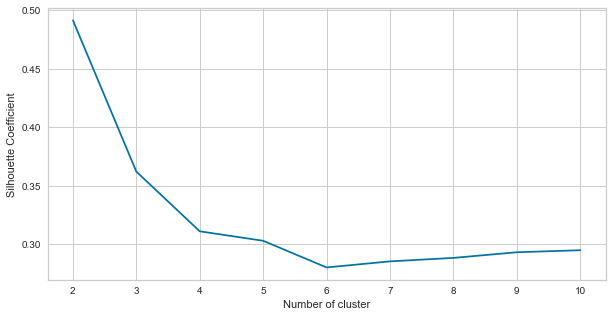

In [63]:
silh_tel = {}
homog_tel = {}
for cluster_size in range(2,11):
    kmeans = KMeans(n_clusters=cluster_size, max_iter=10000, random_state=123).fit(X_churn)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X_churn, label, metric='euclidean')
    homog_score = homogeneity_score(Y_churn, label)
    silh_tel[cluster_size] = sil_coeff
    homog_tel[cluster_size] = homog_score
plt.figure()
plt.plot(list(silh_tel.keys()), list(silh_tel.values()),'bx-' )
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

Text(0, 0.5, 'Silhouette Coefficient')

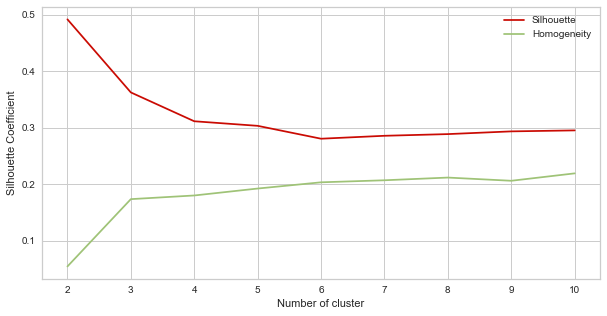

In [64]:
plt.figure()
plt.plot(list(silh_tel.keys()), list(silh_tel.values()), 'r', label="Silhouette")
plt.plot(list(homog_tel.keys()), list(homog_tel.values()), 'g', label="Homogeneity")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")

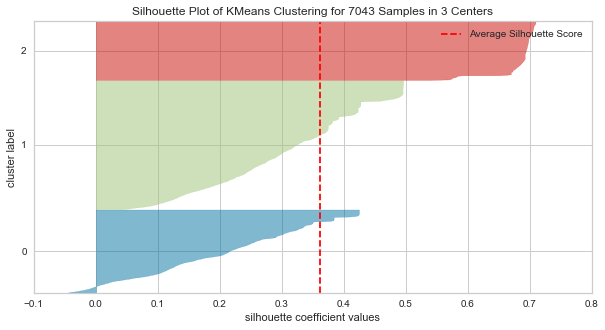

In [67]:
model = KMeans(3, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_churn)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

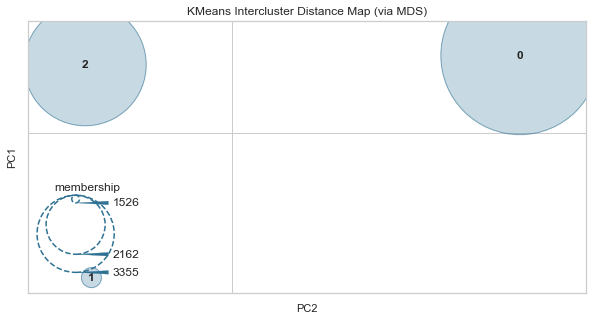

In [69]:
model = KMeans(3)
visualizer = InterclusterDistance(model, random_state=0)
visualizer.fit(X_churn)        # Fit the data to the visualizer
visualizer.show()        #

In [ ]:
# product propensity dataset 

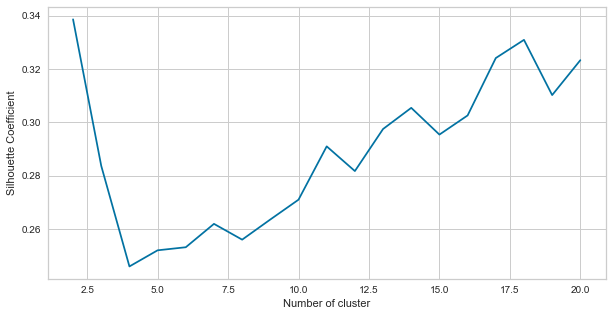

In [73]:

silh_cust = {}
homog_cust = {}
for cluster_size in range(2,21):
    kmeans = KMeans(n_clusters=cluster_size, max_iter=10000, random_state=123).fit(X_cust)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X_cust, label, metric='euclidean')
    homog_score = homogeneity_score(Y_cust, label)
    silh_cust[cluster_size] = sil_coeff
    homog_cust[cluster_size] = homog_score
plt.figure()
plt.plot(list(silh_cust.keys()), list(silh_cust.values()),'bx-' )
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

Text(0, 0.5, 'Silhouette Coefficient')

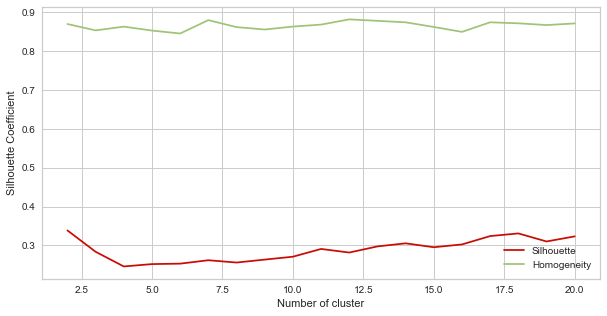

In [74]:
plt.figure()
plt.plot(list(silh_cust.keys()), list(silh_cust.values()), 'r', label="Silhouette")
plt.plot(list(homog_cust.keys()), list(homog_cust.values()), 'g', label="Homogeneity")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")

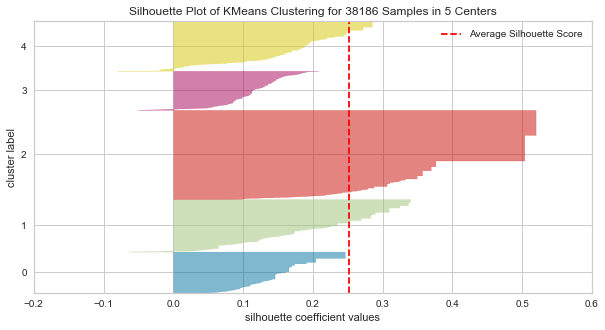

In [75]:
model = KMeans(5, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_cust)        # Fit the data to the visualizer
visualizer.show() 

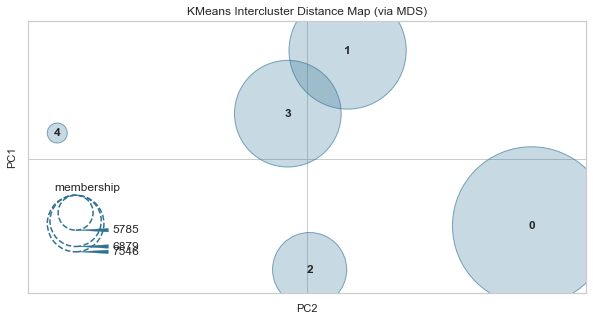

In [76]:
model = KMeans(5)
visualizer = InterclusterDistance(model, random_state=0)
visualizer.fit(X_cust)        # Fit the data to the visualizer
visualizer.show()  

# EXPECTATION MAXIMIZATION

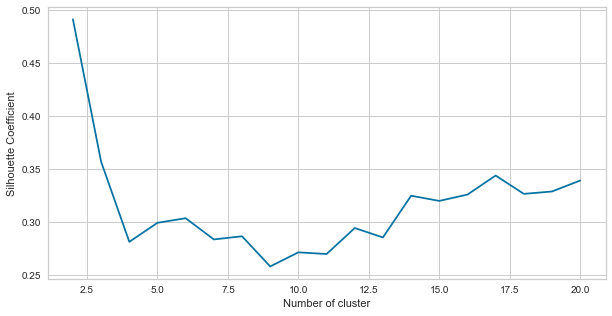

In [86]:
# Churn dataset on EM
silh_tel_em = {}
homog_tel_em = {}
ll_em_tel = {}
for cluster in range(2,21):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=123, 
                          n_init=5).fit(X_churn)
    label = gmm.predict(X_churn)
    sil_coeff = silhouette_score(X_churn, label, metric='euclidean')
    homog_score = homogeneity_score(Y_churn, label)
    silh_tel_em[cluster] = sil_coeff
    homog_tel_em[cluster] = homog_score
    ll_em_tel[cluster] = gmm.score(X_churn)
plt.figure()
plt.plot(list(silh_tel_em.keys()), list(silh_tel_em.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

Text(0, 0.5, 'Silhouette Coefficient')

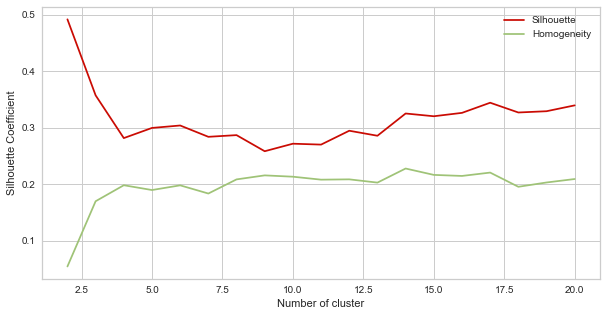

In [92]:
plt.figure()
plt.plot(list(silh_tel_em.keys()), list(silh_tel_em.values()), 'r', label="Silhouette")
plt.plot(list(homog_tel_em.keys()), list(homog_tel_em.values()), 'g', label="Homogeneity")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")

Text(0, 0.5, 'Log Llikelihood')

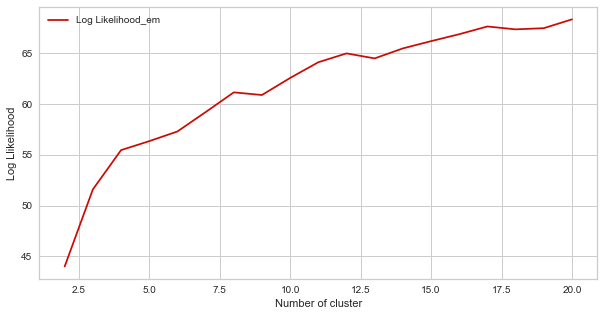

In [87]:
plt.figure()
plt.plot(list(ll_em_tel.keys()), list(ll_em_tel.values()), 'r', label="Log Likelihood_em")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Log Llikelihood")

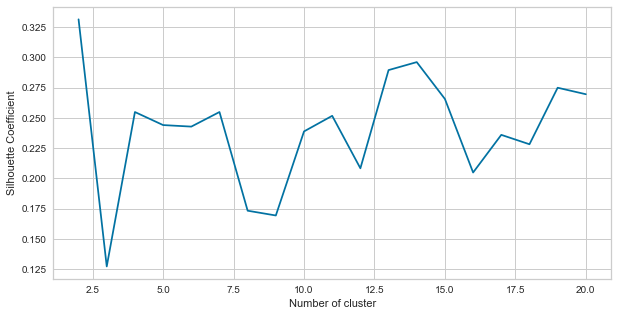

In [88]:
# Churn dataset on EM
silh_cust_em = {}
homog_cust_em = {}
ll_em_cust = {}
for cluster in range(2,21):
    gmm = GaussianMixture(n_components=cluster, max_iter=100, random_state=123, 
                          n_init=5).fit(X_cust)
    label = gmm.predict(X_cust)
    sil_coeff = silhouette_score(X_cust, label, metric='euclidean')
    homog_score = homogeneity_score(Y_cust, label)
    silh_cust_em[cluster] = sil_coeff
    homog_cust_em[cluster] = homog_score
    ll_em_cust[cluster] = gmm.score(X_cust)
plt.figure()
plt.plot(list(silh_cust_em.keys()), list(silh_cust_em.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")
plt.show()

Text(0, 0.5, 'Silhouette Coefficient')

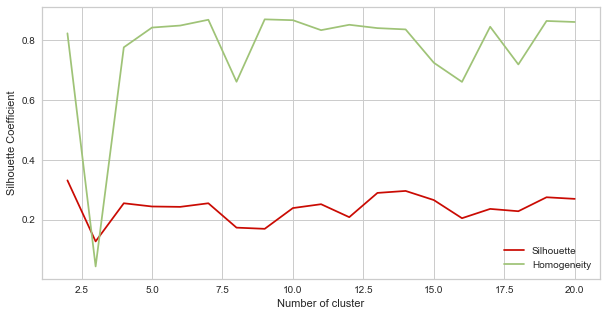

In [91]:
plt.figure()
plt.plot(list(silh_cust_em.keys()), list(silh_cust_em.values()), 'r', label="Silhouette")
plt.plot(list(homog_cust_em.keys()), list(homog_cust_em.values()), 'g', label="Homogeneity")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Coefficient")

Text(0, 0.5, 'Log Llikelihood')

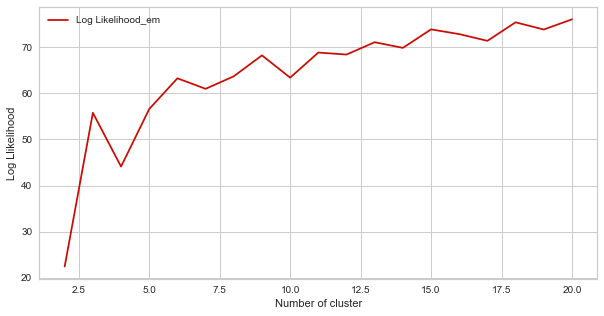

In [90]:
plt.figure()
plt.plot(list(ll_em_cust.keys()), list(ll_em_cust.values()), 'r', label="Log Likelihood_em")
plt.legend()
plt.xlabel("Number of cluster")
plt.ylabel("Log Llikelihood")